<a href="https://colab.research.google.com/github/hmelino/Notebooks/blob/master/HousePrices_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle's House prices
In this notebook we will take Ames Housing dataset from Kaggle's competition and try to predict house prices based on house features.

#Imports

In [0]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn_pandas import CategoricalImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Variables

Let's define our starting variables X and y

- Firstly we will load all our train and test datasets. 

- We will join train and test data into X_full , so we don't have to perform all transformations twice. By joining train and test data we will also avoid for our model to recieve unseen categorical data that were only in test data.

- Variable X will be created by dropping our target called 'SalePrice' , which will be saved as separate variable called y.

In [0]:
train_data=pd.read_csv('/content/drive/My Drive/Reports/home-data-for-ml-course/train.csv')
test_data=pd.read_csv('/content/drive/My Drive/Reports/home-data-for-ml-course/test.csv')
X=train_data.drop('SalePrice',axis=1)
y=train_data['SalePrice']
X_full=pd.concat([X,test_data])

In [55]:
X_full.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,M

In [56]:
X_full.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


#Correlation - numerical features

- To build accurate model we will use the most correlated features with our target 'SalePrice'.

- As our dataset still have categorical data that havent been encoded yet, by using df.corr() we will see only correlation of numerical features.


In [57]:
num_corr=pd.DataFrame(train_data.corr()['SalePrice']).drop('SalePrice',axis=0)
num_corr.index.name='features'
num_corr.rename({'SalePrice':'corr'},axis=1,inplace=True)
num_corr.sort_values('corr',ascending=False,inplace=True)
num_corr.T

features,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,MiscVal,Id,LowQualFinSF,YrSold,OverallCond,MSSubClass,EnclosedPorch,KitchenAbvGr
corr,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,0.507101,0.486362,0.477493,0.466929,0.38642,0.351799,0.324413,0.319334,0.315856,0.284108,0.263843,0.227122,0.214479,0.168213,0.111447,0.092404,0.046432,0.044584,-0.011378,-0.016844,-0.02119,-0.021917,-0.025606,-0.028923,-0.077856,-0.084284,-0.128578,-0.135907


Findings:
- Overall quality seems to have highiest correlation with our target
- Features describing garage adds lots of value as well. 
- Properties with larger living area and more rooms are more expensive as expected. 


#Null values

- Most of models cannot handle missing values. We look for them and try to explain why they are missing. 
- Based on our findings we will replace null values with 0 , 'None' , median value, most occuring category ... etc. 

But before we will start , first we will create copy of our dataframe, so we have original one for comparision. 

In [0]:
features=X_full.copy()

In [59]:
pd.DataFrame(X_full.isnull().sum()[[c for c in X_full.columns if X_full[c].isnull().any()]],columns=['null']).sort_values('null',ascending=False).T

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MasVnrArea,MSZoning,BsmtFullBath,BsmtHalfBath,Functional,Utilities,GarageArea,GarageCars,Electrical,KitchenQual,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,Exterior2nd,Exterior1st,SaleType
null,2909,2814,2721,2348,1420,486,159,159,159,159,157,82,82,81,80,79,24,23,4,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1


- PoolQC have the most missing values from all features. Usually dropping column with too many missing values would help. However this time it looks like missing Pool Quality means missing pool and this information could help us.

- missing MiscFeature is not tragedy as its only shows a special features that could house have, like area to play tennis.

- Garage and Basement features have similar amount of missing values. That gives us a hint that it could mean missing garage/basement. We will have to look deeper to explain rest of missing values. 

##Null values - Garage

####<center>GarageType

In [60]:
X_full.loc[(X_full['GarageType'].isnull())&(X_full['GarageArea']>0)][[c for c in X_full.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond


- By running code above we can confirm that all missing 'GarageType' values mean no garage as GarageArea in same row is 0.



####<center>GarageCond / GarageYrBlt / GarageQual / GarageFinish

- All other garage null values means no garage as well apart of row 666. Here it looks like some features were not imputed and were forgotten. 

In [61]:
#GarageFinish
X_full.loc[(X_full['GarageFinish'].isnull())&(X_full['GarageArea']>0)][[c for c in X_full.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN


In [62]:
#GarageCond
X_full.loc[(X_full['GarageCond'].isnull())&(X_full['GarageArea']>0)][[c for c in X_full.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN


In [63]:
#GarageYrBlt
X_full.loc[(X_full['GarageYrBlt'].isnull())&(X_full['GarageArea']>0)][[c for c in X_full.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN


In [64]:
#GarageQual
X_full.loc[(X_full['GarageQual'].isnull())&(X_full['GarageArea']>0)][[c for c in X_full.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN


In [65]:
for v in ['GarageCond','GarageYrBlt','GarageQual','GarageFinish']:
  print('Mostly used values for ',v)
  print(pd.DataFrame(X_full[v].value_counts()),'\n\n')

Mostly used values for  GarageCond
    GarageCond
TA        2654
Fa          74
Gd          15
Po          14
Ex           3 


Mostly used values for  GarageYrBlt
        GarageYrBlt
2005.0          142
2006.0          115
2007.0          115
2004.0           99
2003.0           92
...             ...
1933.0            1
1943.0            1
1906.0            1
1919.0            1
1896.0            1

[103 rows x 1 columns] 


Mostly used values for  GarageQual
    GarageQual
TA        2604
Fa         124
Gd          24
Po           5
Ex           3 


Mostly used values for  GarageFinish
     GarageFinish
Unf          1230
RFn           811
Fin           719 




Row 666 with missing Garage values can be safely replaced with mostly used categorical value. For Garage year we will use median value.

##<center>Null values - Pool

In [66]:
X_full.loc[(X_full['PoolQC'].isnull()) & (X_full['PoolArea'])>0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1139,2600,20,RL,200.0,43500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,3,5,1953,1953,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,2034,0,0,2034,0.0,0.0,1,0,2,1,TA,9,Min1,0,NaN,2Types,1953.0,RFn,4.0,1041.0,TA,TA,N,483,266,0,0,0,561,NaN,GdPrv,NaN,0,6,2007,WD,Normal


As we can see, all missing PoolQC values can be explained by missing pool apart one in row 1139. We will use value that is most common in this column to replace it. 




##<center>Null values - Alley , Fence , MiscFeature
All Nan values for this features will be replaced with None as properties doesn't have those features as mentioned in documentation.



##<center>Null values - FireplaceQu
This feature can be co-checked with Fireplaces.
And below we can see that all Nan values in FireplaceQuality means no fireplaces, so Nan will be replaced with None.

In [67]:
X_full.loc[(X_full['FireplaceQu'].isnull()) & (X_full['Fireplaces']>0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


##<center>Null values - LotFrontage
Lot frontage is width of pavement connecting road and property, so Nan values will be replaced with 0

##<center>Null values - MasVnrType


23 null values of MasVnrType can be explained as non existent as MasVnrArea is missing as well in same row. 

The 24th missing value can be explained as missing input, probably human error, so we will replace with second most used value 'BrkFace', as first most used value is None.


In [68]:
X_full.loc[(X_full['MasVnrType'].isnull()) & (X_full['MasVnrArea']>0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1150,2611,20,RL,124.0,27697,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,4,3,1961,1961,Shed,CompShg,Plywood,Plywood,NaN,198.0,TA,TA,CBlock,TA,TA,No,BLQ,811.0,Unf,0.0,585.0,1396.0,GasA,TA,N,SBrkr,1608,0,0,1608,0.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1961.0,Unf,1.0,444.0,TA,Fa,Y,152,38,0,0,0,0,NaN,NaN,NaN,0,11,2007,COD,Abnorml


In [69]:
features['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

##<center>Null values - MsZoning , Functional

- MsZoning stands for 'general zoning classification of the sale'.
- Functional is home functionality 

As we can see , none of these values are missing because they dont exist. Most likely they were forgotten, so we will replace it with mostly used values:
- for MsZoning it will be 'RL' - Residential Low Density
- and Functional will be replaced with 'Typ' - Typical Functionality



In [70]:
features['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [71]:
features['Functional'].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

##<center>Null values - Utilities

This feature describe utilies given property have as electricity, gas , electricity + gas , water ... etc. 




In [72]:
y.loc[features.loc[features['Utilities'].isnull()].index]

455    175500
485    147000
Name: SalePrice, dtype: int64

With prices above 147k it is very unlikely for those two properties to not have any utilities at all. Especially as there isn't any other house in this dataset without utilities.

We will replace nulls with mostly used value.


##<center>Null values - TotalBsmtSF

It is pretty common to replace size features with 0 value. 
To be extra sure , we can check all other basement features in given row, for any clues about this missing value.

In [73]:
features.loc[features['TotalBsmtSF'].isnull()][[c for c in features.columns if 'bsmt' in c.lower()]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we know for 100% there is no basement at all and null value can be replaced with 0.

##<center>Null values - GarageCars


In [74]:
features.loc[features['GarageCars'].isnull()][[c for c in features.columns if 'garage' in c.lower()]]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


By co-checking feature with sister features we can explain missing value. 
But in this case we can see that not all missing or 0. Could that be a human error ? 

The safest is to assume that GarageType should be replaced with None as its 6 missing values vs 1.
All other will be replaced with 0 or 'None'.

#Filling Null Values

In [75]:
##Values to be dropped
features.drop(columns=['Id','MiscFeature']) 
#Id column have no value so will be dropped
#MiscFeature have too many missing values and low explainatory value as well.


#The only missing PoolQC value with existing pool will be replaced with mostly used value for PoolQC
features.loc[(features['PoolQC'].isnull()) & (features['PoolArea'])>0]['PoolQC']=features['PoolQC'].mode()

#Rest of missing PoolQC values can be safely replaced with None as there is no Pool
features['PoolQC'].fillna('None',inplace=True)

#Replace that one wrong GarageType to None before we will replace GarageArea with 0
features.loc[features['GarageArea'].isnull()]['GarageType']='None'

#Na Frontage , MasVnrArea
#Size and amount features replaced with 0
for f in ['LotFrontage','MasVnrArea','BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea','GarageYrBlt']:
  features[f].fillna(0,inplace=True)

#Garage and Basement Nan's will be replaced with None - Not existent feature
#MasVnrType will be replaced with None as well. 
for f in ['GarageType','GarageFinish','GarageQual','GarageCond','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1','MasVnrType']:
  features[f].fillna('None',inplace=True)

#Na to None
for f in ['Alley','Fence','MiscFeature','FireplaceQu']:
  features[f].fillna('None',inplace=True)

#Masonry venner type 23x null values are None
features.loc[features['MasVnrArea'].isnull()]['MasVnrType']='None'

#Replace null wih mostly used
for f in ['MSZoning','Utilities','Functional','Exterior1st','Exterior2nd','Electrical','KitchenQual','SaleType']:
  features[f].fillna(features[f].mode()[0],inplace=True)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
#Check if there are any features left with missing values
pd.DataFrame(features.isnull().sum()[[c for c in features.columns if features[c].isnull().any()]],columns=['null']).sort_values('null',ascending=False).T

""
null


No more missing values. We can move on encoding categorical values.

#Categorical values

##Cardinality
In this part we will look at values that are not in numerical format, therefore they need to be transmuted from 'object' type into int or float.

Firstly we will look at cardinality of each categorical feature. Features with high cardinality will be droppped as they would bring too much multidimensionality for low accuracy / explainatory value.

In [77]:
cat_features=features.select_dtypes('object').columns
cat_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

- Features with more than 10 different categorical values are considered to be high cardinal and therefore they would many new columns into dataframe for very low accuracy .

As we are trying to keep our model as simple as possible, we will drop high cardinal values Neighborhood, Exterior2nd, Exterior1st

In [78]:
features[cat_features].nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
HouseStyle        8
Condition2        8
RoofMatl          8
BsmtFinType1      7
BsmtFinType2      7
Functional        7
GarageType        7
Foundation        6
FireplaceQu       6
RoofStyle         6
Heating           6
GarageQual        6
GarageCond        6
SaleCondition     6
BldgType          5
LotConfig         5
ExterCond         5
BsmtQual          5
BsmtCond          5
Electrical        5
MiscFeature       5
Fence             5
MSZoning          5
HeatingQC         5
BsmtExposure      5
KitchenQual       4
GarageFinish      4
ExterQual         4
MasVnrType        4
LandContour       4
LotShape          4
PoolQC            4
PavedDrive        3
LandSlope         3
Alley             3
CentralAir        2
Utilities         2
Street            2
dtype: int64

In [0]:
#Lets drop high cardinal values
features.drop(columns=['Neighborhood','Exterior1st','Exterior2nd'],inplace=True)

As categorical values are not numeric, we cannot check for correlation with Panda's .corr() function. 

We will use Cramér's V.

In [0]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [81]:
for c in cat_features:
  print(c,cramers_v(X[c],y))

MSZoning 0.292440561709249
Street 0.3934516814280061
Alley 0.3179993640019083
LotShape 0.3240087213186113
LandContour 0.13942919066843798
Utilities 0.0
LotConfig 0.14483480003541252
LandSlope 0.1480792440520463
Neighborhood 0.17032977675232583
Condition1 0.0
Condition2 0.1153938944029617
BldgType 0.0
HouseStyle 0.0
RoofStyle 0.0
RoofMatl 0.0
Exterior1st 0.0
Exterior2nd 0.0
MasVnrType 0.2676571484733272
ExterQual 0.44418679896862595
ExterCond 0.3053512909406099
Foundation 0.2214989220254282
BsmtQual 0.3915942382355289
BsmtCond 0.3452981066551993
BsmtExposure 0.28205409045208124
BsmtFinType1 0.0
BsmtFinType2 0.0
Heating 0.3495940524717798
HeatingQC 0.0
CentralAir 0.33568164198038897
Electrical 0.14060169319717547
KitchenQual 0.43429939078961693
Functional 0.0
FireplaceQu 0.26411430466391
GarageType 0.11249660423695168
GarageFinish 0.3438703268436817
GarageQual 0.3159982556614807
GarageCond 0.0
PavedDrive 0.0
PoolQC inf
Fence 0.0
MiscFeature 0.24494897427831863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


SaleType 0.2624594273634847
SaleCondition 0.296247371211342


#Feature engineering
To improve accuracy of our model and reduce dimensionality in our dataset we can combine common features. It will strenghten its correlation and reduce amount of columns.

By grouping features from same group as 'Quality' or 'Size' we can simplify our model.

In [82]:
features.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


## <center>Feature engineering - Quality + Condition

Property quality
We can combine all quality and condition features to simplify our model.

But firstly we will have to encode them into numerical values.

In [83]:
qu_features=['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','PoolQC']

qu_label=set()

for f in qu_features: 
  for l in features[f].unique(): #pick all labels for given feature
    qu_label.add(l) #add them to set , to avoid duplicates

qu_label

{'Ex', 'Fa', 'Gd', 'None', 'Po', 'TA'}

By running code above we picked all unique labels in all features , so we can create scale.

```
  5 Ex:Excelent
  4 Gd:Good
  3 TA:Typical
  2 Fa:Fair
  1 Po:Poor
  0 None:None
```


In [84]:
for f in qu_features:
  features[f].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0},inplace=True)

features[qu_features]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,GarageQual,GarageCond,PoolQC
0,4,3,4,3,5,4,3,3,0
1,3,3,4,3,5,3,3,3,0
2,4,3,4,3,5,4,3,3,0
3,3,3,3,4,4,4,3,3,0
4,4,3,4,3,5,4,3,3,0
...,...,...,...,...,...,...,...,...,...
1454,3,3,3,3,4,3,0,0,0
1455,3,3,3,3,3,3,3,3,0
1456,3,3,3,3,5,3,3,3,0
1457,3,3,4,3,3,3,0,0,0


All Quality features have now numerical values instead , so we can join all scores into one newly created feature called 'Quality'

In [85]:
features['Quality']=features['ExterQual']+features['ExterCond']+features['BsmtQual']+features['BsmtCond']+features['HeatingQC']+features['KitchenQual']+features['GarageQual']+features['PoolQC']+features['OverallQual']
features['Quality']

0       33
1       30
2       33
3       31
4       34
        ..
1454    23
1455    25
1456    28
1457    24
1458    31
Name: Quality, Length: 2919, dtype: int64

In [86]:
pd.DataFrame({'Quality':features['Quality'][0:1460],'SalePrice':y}).corr()

,Quality,SalePrice
Quality,1.000000,0.766728
SalePrice,0.766728,1.000000


Our newly created feature 'Quality' have 0.76 correlation with our target value 'SalePrice'

##<center>Feature engineering - Rooms
Documentation of TotRmsAbvGrd says it excludes bathrooms so will add them, creating new feature called 'Rooms'.

We can group Bath features into one , half baths usually consist of only toilet and sink , so it will be used only as half point and add them to TotRmsAbvGrd.



In [87]:
features['Rooms']=features['BsmtFullBath']+features['BsmtHalfBath']*0.5+features['FullBath']+features['HalfBath']*0.5+features['TotRmsAbvGrd']

pd.DataFrame({'Rooms':features['Rooms'][0:1460],'SalePrice':y}).corr()

,Rooms,SalePrice
Rooms,1.000000,0.647614
SalePrice,0.647614,1.000000


By grouping bath categories we have created new feature called 'Rooms' which have 0.647 correlation with SalePrice.

##<center>Feature engineering - SF 
Here we will group size of :
- 1st floor
- 2nd floor 
- open porch - area usually in front of house , most of times with roof
- total basement 
- wood deck - are usually in back of house , most of times without roof
- screen porch
- pool
- living area above ground
- lenght between road and property
- three season porch area
into new feature called 'SF' - Total square feet

In [88]:
features['SF']=features['1stFlrSF']+features['2ndFlrSF']+features['OpenPorchSF']+features['TotalBsmtSF']+features['WoodDeckSF']\
               +features['ScreenPorch']+features['PoolArea']+features['GrLivArea']+features['GarageArea']+features['LotFrontage']\
               +features['3SsnPorch']

pd.DataFrame({'SF':features['SF'][0:1460],'SalePrice':y}).corr()

,SF,SalePrice
SF,1.000000,0.806542
SalePrice,0.806542,1.000000


Newly created feature shows 0.806 correlation with our target.

#OHE - One Hot Encoding
In this part we will encode our categorical values, so we can use for training.

In [89]:
cat_features=list(features.select_dtypes('object').columns)
ohe=OneHotEncoder(sparse=False)

ohe_features=pd.DataFrame(index=features.index)

for c in cat_features:
  #Fit and transform
  ohe_feat=ohe.fit_transform(features[[c]])
  #Create DataFrame from transformed data , add column names with labels
  ohe_column_names=[c+'_'+v for v in features[c].unique()]
  ohe_feat_df=pd.DataFrame(ohe_feat,columns=ohe_column_names)
  ohe_feat_df.index=features.index

  for col in ohe_column_names:
    features[col]=ohe_feat_df[col]

  features.drop(c,axis=1,inplace=True)
features

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,...,FireplaceQu_Po,GarageType_Attchd,GarageType_Detchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_None,GarageType_Basment,GarageType_2Types,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Fin,GarageFinish_None,PavedDrive_Y,PavedDrive_N,PavedDrive_P,Fence_None,Fence_MnPrv,Fence_GdWo,Fence_GdPrv,Fence_MnWw,MiscFeature_None,MiscFeature_Shed,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_TenC,SaleType_WD,SaleType_New,SaleType_COD,SaleType_ConLD,SaleType_ConLI,SaleType_CWD,SaleType_ConLw,SaleType_Con,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,1,60,65.0,8450,7,5,2003,2003,196.0,4,3,4,3,706.0,0.0,150.0,856.0,5,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,0,2003.0,2.0,548.0,3,3,0,61,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,3,3,4,3,978.0,0.0,284.0,1262.0,5,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,1,1976.0,2.0,460.0,3,3,298,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,4,3,4,3,486.0,0.0,434.0,920.0,5,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,1,2001.0,2.0,608.0,3,3,0,42,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,3,3,3,4,216.0,0.0,540.0,756.0,4,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,1,1998.0,3.0,642.0,3,3,0,35,272,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,4,3,4,3,655.0,0.0,490.0,1145.0,5,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,1,2000.0,3.0,836.0,3,3,192,84,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,3,3,3,3,0.0,0.0,546.0,546.0,4,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,0,0.0,0.0,0.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,3,3,3,3,252.0,0.0,294.0,546.0,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,0,1970.0,1.0,286.0,3,3,0,24,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,3,3,3,3,1224.0,0.0,0.0,1224.0,5,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,1,1960.0,2.0,576.0,3,3,474,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,3,3,4,3,337.0,0.0,575.0,912.0,3,970,0,0,970,0.0,1.0,1,0,3,1,3,6,0,0.0,0.0,0.0,0,0,80,32,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.

#Train

Firstly we will create lists to keep all scores.

In [0]:
model_scores=[]
model_names=[]

Firstly we will split our data into train and test/validate parts. We will use train_test_split feature.

For X we will use our transformed dataset called 'features', specificly only rows with index 0:1460 as that are rows that have also target value - 'SalePrice'. 

By previously joining training and test datasets, we dont have to perform all previous transformations again on test dataset.

In [0]:
X_train,X_val,y_train,y_val=train_test_split(features[0:1460],y,random_state=10) #we are selecting Random state so we will recieve same results
engineered_cols=['Rooms','SF','Quality']

##Fit N.1 - all features 

In very first fit we will use all transformed columns exluding our special engineered features.

In [92]:
fit_1_model=RandomForestRegressor()
fit_1_model.fit(X_train.drop(columns=engineered_cols),y_train)


print('MAE',mean_absolute_error(y_val,fit_1_model.predict(X_val.drop(columns=engineered_cols))))

MAE 18766.041835616437


###Cross validation score

In [93]:
cv_scores = cross_val_score(estimator=fit_1_model,X=X_train.drop(columns=engineered_cols),y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.1')

print('Cross validation score' ,cv_s)

Cross validation score 0.8499029149171371


Our model have at this stage 215 features. 

We will try to remove less significant ones to improve accuracy and simplify model.


##Fit N.2 Only engineered features

In [94]:
model=RandomForestRegressor()
selected_features=['SF','Quality','Rooms']
model.fit(X_train[selected_features],y_train)

mean_absolute_error(y_val,model.predict(X_val[selected_features]))

22416.005073711676

This is pretty good model for using only 3 features. 

###Cross validation score

In [95]:
cv_scores = cross_val_score(estimator=model,X=X_train[selected_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.2')

print('Cross validation score ',cv_s)

Cross validation score  0.8091533588092584


##Fit N.3 Adding most correlated numerical features

Lets add some more highly correlated features that we havent touched in  Feature engineering part.

in code below we will:
- get all column names from features DataFrame
- remove OneHotEncoded features that have '_' in their name
- remove already processed features (Feature engineering)
- add 'SalePrice' column
- count correlation between 'SalePrice' and all features that havent been removed in process described above
- create a dataset from correlation data recieved 
- drop 'SalePrice' column from correlation as it have 1.0 correlation with itself
- sort it by highiest correlation 
- transpose rows as columns (flip x and y of our df )

We were using sets to for easier manipulations with collection of columns

In [96]:
already_processed = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','PoolQC']\
                    +['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd']\
                    +['1stFlrSF','2ndFlrSF','OpenPorchSF','TotalBsmtSF','WoodDeckSF','ScreenPorch','PoolArea','GrLivArea','GarageArea','LotFrontage']\
                    +['3SsnPorch']

pd.DataFrame(train_data[list( (set([c for c in features.columns if '_' not in c]) | set(['SalePrice'])) - set(already_processed) - set(engineered_cols) )]\
             .corr()['SalePrice'])\
             .drop('SalePrice',axis=0)\
             .sort_values(by='SalePrice',ascending=False)\
             .T

,OverallQual,GarageCars,YearBuilt,YearRemodAdd,GarageYrBlt,MasVnrArea,Fireplaces,BsmtFinSF1,LotArea,BsmtUnfSF,BedroomAbvGr,MoSold,BsmtFinSF2,MiscVal,Id,LowQualFinSF,YrSold,OverallCond,MSSubClass,EnclosedPorch,KitchenAbvGr
SalePrice,0.790982,0.640409,0.522897,0.507101,0.486362,0.477493,0.466929,0.38642,0.263843,0.214479,0.168213,0.046432,-0.011378,-0.02119,-0.021917,-0.025606,-0.028923,-0.077856,-0.084284,-0.128578,-0.135907


###Cross validation score

In [97]:
model=RandomForestRegressor()
selected_features=['SF','Quality','Rooms','YearBuilt','YearRemodAdd','Fireplaces']
model.fit(X_train[selected_features],y_train)

mean_absolute_error(y_val,model.predict(X_val[selected_features]))

19342.28479712981

Thats an improvement already !

In [98]:
cv_scores = cross_val_score(estimator=model,X=X_train[selected_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.3')

print('Cross validation score ',cv_s)

Cross validation score  0.8298489264172677


##Fit N.4 The best categorical values

This time we will dive deep into our categorical values in search for the ones that would help us create more accurate model.

We will create function that will add categorical features separatelly and compare if there is any improvement in MAE - MeanAbsoluteError

By creating dictionary of all categorical features and its variables , as seen below, we can choose which features to use.


In [99]:
X_full=pd.concat([X,test_data])
cat_encoded_dict={c:[v for v in features.columns if c in v] for c in X_full[cat_features].columns}
cat_encoded_dict

{'Alley': ['Alley_None', 'Alley_Grvl', 'Alley_Pave'],
 'BldgType': ['BldgType_1Fam',
  'BldgType_2fmCon',
  'BldgType_Duplex',
  'BldgType_TwnhsE',
  'BldgType_Twnhs'],
 'BsmtExposure': ['BsmtExposure_No',
  'BsmtExposure_Gd',
  'BsmtExposure_Mn',
  'BsmtExposure_Av',
  'BsmtExposure_None'],
 'BsmtFinType1': ['BsmtFinType1_GLQ',
  'BsmtFinType1_ALQ',
  'BsmtFinType1_Unf',
  'BsmtFinType1_Rec',
  'BsmtFinType1_BLQ',
  'BsmtFinType1_None',
  'BsmtFinType1_LwQ'],
 'BsmtFinType2': ['BsmtFinType2_Unf',
  'BsmtFinType2_BLQ',
  'BsmtFinType2_None',
  'BsmtFinType2_ALQ',
  'BsmtFinType2_Rec',
  'BsmtFinType2_LwQ',
  'BsmtFinType2_GLQ'],
 'CentralAir': ['CentralAir_Y', 'CentralAir_N'],
 'Condition1': ['Condition1_Norm',
  'Condition1_Feedr',
  'Condition1_PosN',
  'Condition1_Artery',
  'Condition1_RRAe',
  'Condition1_RRNn',
  'Condition1_RRAn',
  'Condition1_PosA',
  'Condition1_RRNe'],
 'Condition2': ['Condition2_Norm',
  'Condition2_Artery',
  'Condition2_RRNn',
  'Condition2_Feedr',
  'Con



For keeping the code clean , we will create function to keep extra variables inside.

This function calculates MAE for each group of features and picks the most significant one. After it adds chosen feature and repeats process. 

In [100]:
%%time
def find_best_cat_features():
  """ This function will try all groups of categorical features and compare their effectiveness in making our model more accurate""" 

  X_full=pd.concat([X,test_data])
  #This line will create dictionary of cat_values and list of encoded column names

  cat_encoded_dict={c:[v for v in features.columns if c in v] for c in X_full[cat_features].columns}

  model=RandomForestRegressor()
  base_features=['SF','Quality','Rooms','YearBuilt','YearRemodAdd','Fireplaces']
  model.fit(X_train[base_features],y_train)
  prediction = model.predict(X_val[base_features])
  base_score = mean_absolute_error(y_val,prediction)

  scores=[]
  for c in cat_encoded_dict.keys():
    extra_features=cat_encoded_dict[c]
    checked_features=base_features+extra_features
    model.fit(X_train[checked_features],y_train)
    prediction = model.predict(X_val[checked_features])
    score = mean_absolute_error(y_val,prediction)
    scores.append(base_score-score)


  return pd.DataFrame({'Feature':list(cat_encoded_dict.keys()),\
                       'Improvement':scores}).sort_values('Improvement',ascending=False)

print(find_best_cat_features())

          Feature  Improvement
17   BsmtFinType1   662.445187
16   BsmtExposure   519.715297
0        MSZoning   518.228502
9      Condition2   342.740880
10       BldgType   341.226694
14     MasVnrType   235.685589
24     GarageType   169.750725
6       LotConfig   168.534724
29       SaleType   168.055763
28    MiscFeature   132.989224
8      Condition1   117.575209
7       LandSlope   112.177083
5       Utilities   101.953005
15     Foundation    84.217233
20     CentralAir    78.751187
27          Fence    74.809598
30  SaleCondition    60.400128
25   GarageFinish    29.507826
19        Heating    28.794775
2           Alley    25.218703
4     LandContour    -8.097576
22     Functional   -25.148308
11     HouseStyle   -32.644164
1          Street   -39.661292
21     Electrical   -52.043872
23    FireplaceQu   -91.343023
26     PavedDrive   -98.348151
13       RoofMatl  -109.275709
18   BsmtFinType2  -165.334973
3        LotShape  -207.955781
12      RoofStyle  -237.246000
CPU time

In [0]:
bsmtFin_features=cat_encoded_dict['BsmtFinType1']
functional_features=cat_encoded_dict['Functional']
fence_features=cat_encoded_dict['Fence']
lotConfig_features=cat_encoded_dict['LotConfig']
garageFinish_features=cat_encoded_dict['GarageFinish']

In [102]:
model=RandomForestRegressor()
selected_features=['SF','Quality','Rooms','YearBuilt','YearRemodAdd','Fireplaces']+bsmtFin_features+functional_features+fence_features\
                  +lotConfig_features+garageFinish_features
model.fit(X_train[selected_features],y_train)

mean_absolute_error(y_val,model.predict(X_val[selected_features]))

18996.13485844749

###Cross validation score

In [103]:
cv_scores = cross_val_score(estimator=model,X=X_train[selected_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.4')

print('Cross validation score ',cv_s)

Cross validation score  0.8327842285966247


##Fit N.5 RFE estimator

Sklearn have its own estimator to most valuable features. RFE estimator will remove least effective features.
`

###<center>RFE max_iter=250

In [104]:
%%time
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter=250), n_features_to_select=10, step=20, verbose=5)
rfe_selector.fit(X_train, y_train)

Fitting estimator with 215 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 195 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 175 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 155 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 135 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 115 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 95 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 75 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 55 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 35 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 15 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 51min 41s, sys: 28min 39s, total: 1h 20min 20s
Wall time: 40min 56s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


After running RFE estimator for over 7 minutes we have recieved 10 'most valuable' features.
-  What is the MAE score ? 
- Was it worth waiting ? 

We will find answers for this questions.

In [123]:
X_train.loc[:,rfe_selector.get_support()]

,MSSubClass,LotFrontage,YearBuilt,YearRemodAdd,MasVnrArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,YrSold
567,20,70.0,2004,2004,168.0,532.0,0,0,0,2010
1416,190,60.0,1885,1950,0.0,560.0,0,0,114,2010
1372,60,75.0,1998,1998,0.0,583.0,253,170,0,2006
172,160,44.0,1987,1987,0.0,504.0,441,35,0,2006
810,20,78.0,1974,1999,99.0,484.0,265,0,0,2006
...,...,...,...,...,...,...,...,...,...,...
1393,190,60.0,1905,2000,0.0,672.0,0,25,212,2008
1344,60,85.0,2006,2006,0.0,440.0,0,0,0,2007
527,60,67.0,2008,2008,268.0,858.0,126,66,0,2008
1149,70,50.0,1920,1988,0.0,324.0,0,0,0,2009


- It is strange to see 'Id' column in 'best features'  as usually it doesnt have any value and its usually dropped at very beginning.
- Size of Basement, second floor and garage area made it as well including our custom feature 'SF'

- Our 'Quality' and 'Rooms' didnt make it into this selection

In [106]:
model=RandomForestRegressor()
selected_features=['Id','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GarageArea','YrSold','SF']
model.fit(X_train[selected_features],y_train)

mean_absolute_error(y_val,model.predict(X_val[selected_features]))

25632.39021917808

###Cross validation score

In [107]:
cv_scores = cross_val_score(estimator=model,X=X_train[selected_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.5')

print('Cross validation score ',cv_s)

Cross validation score  0.7785785185400832


MAE error is 25482 which is much more comparing to our 3 feature model with [Quality,Rooms,SF].



###<center>RFE max_iter=3000


Even with max_iter=3000 we are still getting ITERATIONS LIMIT

Here is code that was running

IN
```
%%time
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter=3000), n_features_to_select=10, step=20, verbose=5)
rfe_selector.fit(X_train, y_train)
```


OUT
```
Fitting estimator with 215 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 195 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 175 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 155 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 135 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 115 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 95 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 75 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 55 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 35 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
Fitting estimator with 15 features.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
CPU times: user 51min 41s, sys: 28min 39s, total: 1h 20min 20s
Wall time: 40min 56s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
```


This code ran for almost 52 minutes. Did we get better features ? 


IN
```
model=RandomForestRegressor()
selected_features=['MSSubClass','LotFrontage','YearBuilt','YearRemodAdd','MasVnrArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','YrSold']
model.fit(X_train[selected_features],y_train)

mean_absolute_error(y_val,model.predict(X_val[selected_features]))
```

OUT


```
29905.721161643833
```

Even Cross validation score was worse, falling to 0.6391799463298466.






##Fit N.6 BestCatFeature
We will tweak our BestCatFeature to choose all our features. 

In [108]:
%%time

class BestCatFeature:
  all_features_list=[]
  final_features_list=None


  def __init__(self,steps=200):
    """ This function will try all groups of categorical features and compare their effectiveness in making our model more accurate""" 

    X_full=pd.concat([X,test_data])

    #This line will create dictionary of cat_values and list of encoded column names
    feature_dict={c:[v for v in features.columns if c in v] for c in X_full[cat_features].columns}
    num_features=X_full.select_dtypes(exclude='object')


    #model=RandomForestRegressor(n_jobs=-1) tiny bit more accurate, but took 1h 3min 9s vs 35.6 s
    model=LinearRegression(n_jobs=-1)
    base_features=['SF','Quality','Rooms','YearBuilt']
    model.fit(X_train[base_features],y_train)
    prediction = model.predict(X_val[base_features])
    base_score = mean_absolute_error(y_val,prediction)
    print('Starting score',base_score)


    #add all numerical values into dicionary
    for n in num_features:
      feature_dict[n]=[n]

    #Prevent out of index error if steps value is highier than amount of avialable features.
    total_features=len(list(feature_dict.keys()))
    if steps>total_features:
      steps=total_features

    best_score=base_score
    found_best=False

    for step in range(0,steps):
      scores={}
      for feature_name in list(feature_dict.keys()):
        checked_features=base_features+feature_dict[feature_name] #add features that have been chosen for fitting 
        model.fit(X_train[checked_features],y_train)
        prediction = model.predict(X_val[checked_features])
        score = mean_absolute_error(y_val,prediction) 
        scores[round(score,3)]=feature_name
      
      best_feature_score=min(list(scores.keys()))
      best_feature_name=scores[best_feature_score]

      #keep the best score and the best features
      if best_feature_score<best_score and found_best==False:
        best_score=best_feature_score
        self.final_features_list=base_features
      elif best_feature_score>best_score:
        found_best=True
      
      if best_feature_score>base_score:
        break

      print(best_feature_score,best_feature_name)
      base_features+=feature_dict[best_feature_name]
      self.all_features_list.append([best_feature_score,best_feature_name,len(base_features)])
      del feature_dict[best_feature_name]

      #Amount of features used + 4 base ones 
      f_len=len(base_features)+4




    model=RandomForestRegressor()
    model.fit(X_train[base_features],y_train)
    final_score = mean_absolute_error(y_val,model.predict(X_val[base_features]))
    features_n=len(base_features)
    print(f'Final score :{final_score} for {features_n} features')
    #return features_n,final_score


f=BestCatFeature()

Starting score 25432.386950251712
24315.541 BsmtExposure
23570.997 MSSubClass
22738.848 OverallQual
22259.912 BedroomAbvGr
21844.715 GarageFinish
21465.533 Functional
21200.361 BsmtUnfSF
20906.212 SaleType
20687.049 BldgType
20510.134 PoolArea
20335.562 OverallCond
20200.508 HouseStyle
20092.246 Condition2
19982.563 GarageYrBlt
19881.115 Condition1
19741.623 LotShape
19613.705 GarageType
19523.873 OpenPorchSF
19444.795 MSZoning
19399.551 HalfBath
19360.775 MasVnrType
19202.843 MasVnrArea
19060.205 BsmtFinType1
19010.847 GarageArea
18973.314 BsmtHalfBath
18965.198 LowQualFinSF
18951.286 FullBath
18948.719 Id
18948.058 MiscVal
18907.863 MiscFeature
18907.863 YearBuilt
18908.278 TotRmsAbvGrd
18908.278 BsmtFullBath
18908.995 Utilities
18912.185 CentralAir
18919.81 EnclosedPorch
18939.791 3SsnPorch
18964.77 Foundation
18969.518 GrLivArea
18992.707 LotFrontage
19016.694 YrSold
19043.553 MoSold
19065.529 LotArea
19112.098 Fence
19154.566 YearRemodAdd
19202.055 BsmtFinSF2
19267.095 ScreenPorch

Our custom feature selector took only 34 seconds to finish , which is 11x faster than RFE estimator. 

And MAE score is only above 18 thousands , giving us 29% increase in accuracy. 

In [109]:
%%time
best_features=set(f.final_features_list+['Rooms','Quality','SF','YearBuilt'])
model_test=RandomForestRegressor(n_jobs=-1)
model_test.fit(X_train[best_features],y_train)
print(mean_absolute_error(y_val,model_test.predict(X_val[best_features])))

18542.20126027397
CPU times: user 3.44 s, sys: 30.1 ms, total: 3.47 s
Wall time: 1.96 s


###Cross validation score

In [110]:
cv_scores = cross_val_score(estimator=model,X=X_train[best_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.6')

print('Cross validation score ',cv_s)

Cross validation score  0.858781261792371


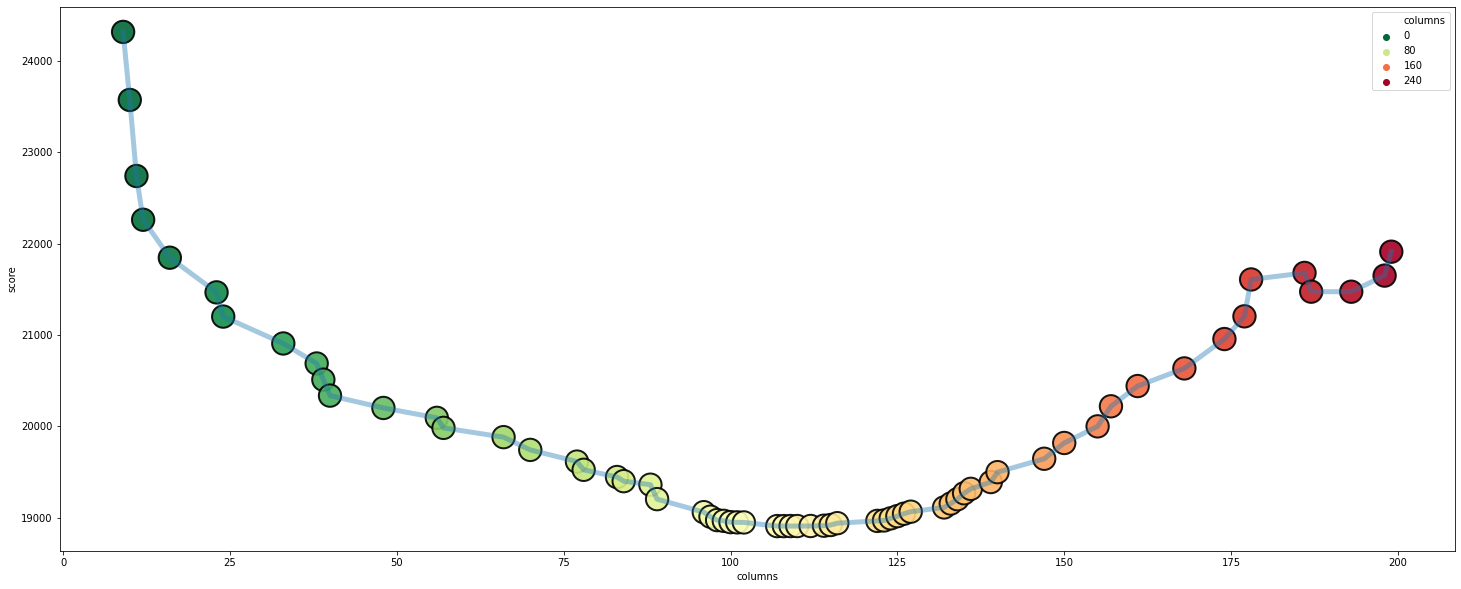

In [111]:
best_feature_df=pd.DataFrame(f.all_features_list,columns=['score','feature','columns'])
best_feature_df

plt.figure(figsize=[25,10])
#plt.title('Dimensionality of dataset vs performance')
plt.plot(best_feature_df['columns'][:-2],best_feature_df['score'][:-2],linewidth=5,alpha=0.4)
sns.scatterplot(data=best_feature_df[:-2],x='columns',y='score',s=500,alpha=0.9,palette='RdYlGn_r',hue='columns',linewidth=2,edgecolor='black',)

plt.show()

##Fit N.7 XGBRegressor

By now we have chosen best features.

We will use XGBoost Regressor for further improvements. 

In [112]:
%%time
model=XGBRegressor(n_jobs=-1,learning_rate=0.05,n_estimators=300)
model.fit(X_train[best_features],y_train,eval_set=[(X_val[best_features],y_val)])
print(mean_absolute_error(y_val,model.predict(X_val[best_features],)))

[22:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:187162
[1]	validation_0-rmse:178479
[2]	validation_0-rmse:170225
[3]	validation_0-rmse:162464
[4]	validation_0-rmse:155148
[5]	validation_0-rmse:148140
[6]	validation_0-rmse:141434
[7]	validation_0-rmse:135184
[8]	validation_0-rmse:129071
[9]	validation_0-rmse:123315
[10]	validation_0-rmse:117869
[11]	validation_0-rmse:112620
[12]	validation_0-rmse:107819
[13]	validation_0-rmse:103140
[14]	validation_0-rmse:98674.9
[15]	validation_0-rmse:94504.4
[16]	validation_0-rmse:90545.2
[17]	validation_0-rmse:86735.1
[18]	validation_0-rmse:83220.5
[19]	validation_0-rmse:79915.5
[20]	validation_0-rmse:76697.3
[21]	validation_0-rmse:73737.4
[22]	validation_0-rmse:70856.4
[23]	validation_0-rmse:68238.5
[24]	validation_0-rmse:65823
[25]	validation_0-rmse:63458.9
[26]	validation_0-rmse:61335.3
[27]	validation_0-rmse:59151.5
[28]	validation_0-rmse:57241
[2

###Cross validation score

In [113]:
cv_scores = cross_val_score(estimator=model,X=X_train[best_features],y=y_train,cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.7')

print('Cross validation score ',cv_s)

[22:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross validation score  0.8745034930179478


##Fit N.8  XGBRegressor - log y

How we could further improve this score ? We can have a look at distribution of target. Skewiness to one side could be negativelly influencing our predicted prices.

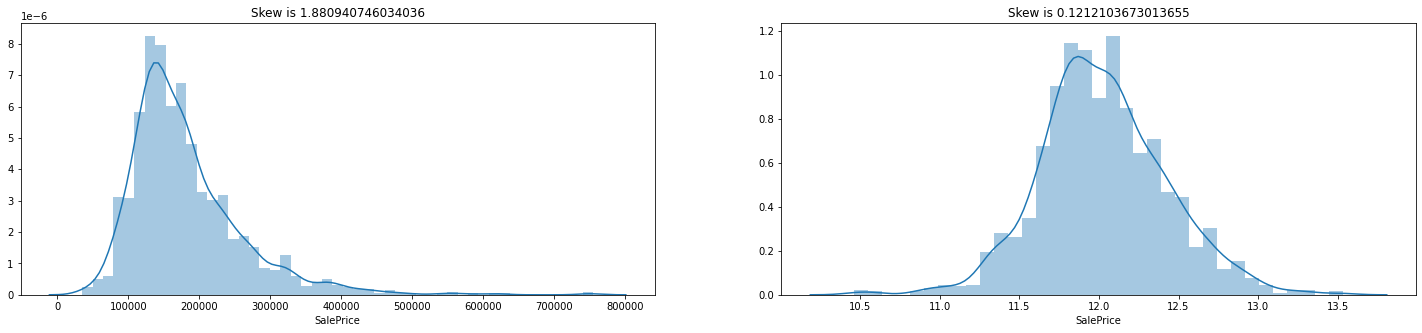

In [114]:
plt.figure(figsize=[25,5])

plt.subplot(1,2,1)
sns.distplot(y).set_title(f'Skew is {ss.skew(y)}')

plt.subplot(1,2,2)
sns.distplot(np.log(y)).set_title(f'Skew is {ss.skew(np.log(y))}')

plt.show()

Could this improve accuracy ? Maybe , lets have a look.

In [115]:
X_train,X_val,y_log_train,y_log_val=train_test_split(features[0:1460],np.log(y),random_state=10) 

model=XGBRegressor(n_jobs=-1,learning_rate=0.05,n_estimators=100,)
model.fit(X_train[best_features],y_log_train,eval_set=[(X_val[best_features],y_log_val)])

print(mean_absolute_error(y_val,
                          np.sqrt(model.predict(X_val[best_features],))))

[22:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:10.9406
[1]	validation_0-rmse:10.3938
[2]	validation_0-rmse:9.87443
[3]	validation_0-rmse:9.38103
[4]	validation_0-rmse:8.91233
[5]	validation_0-rmse:8.46709
[6]	validation_0-rmse:8.04437
[7]	validation_0-rmse:7.64338
[8]	validation_0-rmse:7.26169
[9]	validation_0-rmse:6.89938
[10]	validation_0-rmse:6.55557
[11]	validation_0-rmse:6.22872
[12]	validation_0-rmse:5.91805
[13]	validation_0-rmse:5.62328
[14]	validation_0-rmse:5.34302
[15]	validation_0-rmse:5.07691
[16]	validation_0-rmse:4.82452
[17]	validation_0-rmse:4.58402
[18]	validation_0-rmse:4.3558
[19]	validation_0-rmse:4.13877
[20]	validation_0-rmse:3.93329
[21]	validation_0-rmse:3.73778
[22]	validation_0-rmse:3.55207
[23]	validation_0-rmse:3.37574
[24]	validation_0-rmse:3.20852
[25]	validation_0-rmse:3.04926
[26]	validation_0-rmse:2.89768
[27]	validation_0-rmse:2.754
[28]	validation_0-

In [116]:
%%time
best_features=set(f.final_features_list+['Rooms','Quality','SF','YearBuilt'])
model_test=RandomForestRegressor(n_jobs=-1)
model_test.fit(X_train[best_features],y_log_train)
print('MAE',mean_absolute_error(y_val,np.sqrt(model_test.predict(X_val[best_features]))))

scores = cross_val_score(estimator=model_test,X=X_train[best_features],y=y_train,cv=5)
print('Score ',sum(scores)/len(scores))

MAE 179205.15469070894
Score  0.8594632067531995
CPU times: user 4.4 s, sys: 196 ms, total: 4.6 s
Wall time: 11.2 s


In [117]:
%%time
model=XGBRegressor(n_jobs=-1,learning_rate=0.05,n_estimators=300)
model.fit(X_train[best_features],y_train,eval_set=[(X_val[best_features],y_val)])
print(mean_absolute_error(y_val,model.predict(X_val[best_features],)))

[22:05:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:187162
[1]	validation_0-rmse:178479
[2]	validation_0-rmse:170225
[3]	validation_0-rmse:162464
[4]	validation_0-rmse:155148
[5]	validation_0-rmse:148140
[6]	validation_0-rmse:141434
[7]	validation_0-rmse:135184
[8]	validation_0-rmse:129071
[9]	validation_0-rmse:123315
[10]	validation_0-rmse:117869
[11]	validation_0-rmse:112620
[12]	validation_0-rmse:107819
[13]	validation_0-rmse:103140
[14]	validation_0-rmse:98674.9
[15]	validation_0-rmse:94504.4
[16]	validation_0-rmse:90545.2
[17]	validation_0-rmse:86735.1
[18]	validation_0-rmse:83220.5
[19]	validation_0-rmse:79915.5
[20]	validation_0-rmse:76697.3
[21]	validation_0-rmse:73737.4
[22]	validation_0-rmse:70856.4
[23]	validation_0-rmse:68238.5
[24]	validation_0-rmse:65823
[25]	validation_0-rmse:63458.9
[26]	validation_0-rmse:61335.3
[27]	validation_0-rmse:59151.5
[28]	validation_0-rmse:57241
[2

###Cross validation score

In [118]:
cv_scores = cross_val_score(estimator=model,X=X_train[best_features],y=np.log(y_train),cv=5)
cv_s = sum(cv_scores)/len(cv_scores)

model_scores.append(cv_s)
model_names.append('N.8')

print('Cross validation score ',cv_s)

[22:05:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Cross validation score  0.893016133830384


##Cross Validation Results

Which model is the best ? Lets have a look at all cross validatin scores we have collected.

In [119]:
model_scores
model_names
pd.DataFrame({'name':model_names,'score':model_scores})

,name,score
0,N.1,0.849903
1,N.2,0.809153
2,N.3,0.829849
3,N.4,0.832784
4,N.5,0.778579
5,N.6,0.858781
6,N.7,0.874503
7,N.8,0.893016


Model N.8 shows the highiest score, so we will use it for Kaggle competition submission.

#Pipeline

Pipeline is handy for organising code, and its essential for Cross Validation. 

As model we will use XGBRegressor as it gave use best results.


In [120]:
pipe=Pipeline(steps=[
                     #('transformer',transformer),
                     ('model',XGBRegressor(n_jobs=-1,learning_rate=0.05,n_estimators=3000))
])

pipe.fit(X=features[selected_features][0:1460],y=train_data['SalePrice'])
pipe.predict(features[selected_features][1460:])

[22:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([158666.42, 183792.06, 200157.  , ..., 196590.95,  89691.42,
       262799.6 ], dtype=float32)

#Competition

In [121]:
%%time
model_kaggle_log=XGBRegressor(n_jobs=-1,learning_rate=0.05,n_estimators=3000)
model_kaggle_log.fit(features[selected_features][0:1460],np.log(train_data['SalePrice']))
predicted_prices=model_kaggle_log.predict(features[selected_features][1460:])

[22:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 6.03 s, sys: 44.5 ms, total: 6.07 s
Wall time: 3.1 s


In [0]:
pd.DataFrame({'SalePrice':predicted_prices},index=features[1460:]['Id']).to_csv('Submission.csv')